In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle

import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

pd.set_option('max_columns', None)

In [2]:
summer_2019 = pd.read_excel('2019-summer-2019-07-08.xlsx')
spring_2019 = pd.read_excel('2019-spring-2019-05-21.xlsx')
#summer_2019 = pd.read_excel('2019-summer-2019-06-24.xlsx')
#summer_2018 = pd.read_excel('2018-summer-2018-09-27.xlsx')
#spring_2018 = pd.read_excel('2018-spring-2018-05-20.xlsx')

## Feature engineering

In [3]:
spring_2019[spring_2019.gameid == 880970]

,gameid,url,league,split,date,week,game,patchno,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,k,d,a,teamkills,teamdeaths,doubles,triples,quadras,pentas,fb,fbassist,fbvictim,fbtime,kpm,okpm,ckpm,fd,fdtime,teamdragkills,oppdragkills,elementals,oppelementals,firedrakes,waterdrakes,earthdrakes,airdrakes,elders,oppelders,herald,heraldtime,ft,fttime,firstmidouter,firsttothreetowers,teamtowerkills,opptowerkills,fbaron,fbarontime,teambaronkills,oppbaronkills,dmgtochamps,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,wardshare,wardkills,wcpm,visionwards,visionwardbuys,visiblewardclearrate,invisiblewardclearrate,totalgold,earnedgpm,goldspent,gspd,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,oppgoldat10,gdat10,goldat15,oppgoldat15,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
3084,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,1,Blue,Top,Odoamne,Schalke 04,Ryze,Draven,Cassiopeia,Urgot,Syndra,Zoe,30.016667,0,0,4,0,2,13,0,0,0,0,0,0.0,0,11.3914,0,0.0333148,0.499722,0,10.151017,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,14.9581,0.0,0.0,2.0,11.0,0.0,24.3038,0.0,1.0,5690.0,189.561355,0.164498,0.197778,11.0,0.366463,0.106796,5.0,0.166574,3.0,4.0,,,9878.0,197.502277,8900.0,-0.156396,245.0,5.0,2.0,0.0,8.328706,3324.0,3391.0,-67.0,4927.0,4921.0,6.0,4706.0,4934.0,-228.0,92.0,94.0,-2.0,136.0,140.0,-4.0
3085,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,2,Blue,Jungle,Memento,Schalke 04,Camille,Draven,Cassiopeia,Urgot,Syndra,Zoe,30.016667,0,0,4,2,2,13,0,0,0,0,0,0.0,0,11.3914,0,0.0666297,0.499722,0,10.151017,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,14.9581,0.0,0.0,2.0,11.0,0.0,24.3038,0.0,1.0,6637.0,221.110494,0.191876,0.150438,11.0,0.366463,0.106796,5.0,0.166574,6.0,9.0,,,8459.0,150.228540,8283.0,-0.082972,8.0,134.0,105.0,4.0,4.730705,2878.0,3096.0,-218.0,4264.0,4248.0,16.0,3115.0,3605.0,-490.0,52.0,61.0,-9.0,81.0,82.0,-1.0
3086,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,3,Blue,Middle,Abbedagge,Schalke 04,Lissandra,Draven,Cassiopeia,Urgot,Syndra,Zoe,30.016667,0,0,2,1,2,13,0,0,0,0,0,0.0,0,11.3914,0,0.133259,0.499722,0,10.151017,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,14.9581,0.0,0.0,2.0,11.0,0.0,24.3038,0.0,1.0,5367.0,178.800666,0.15516,0.233175,13.0,0.433093,0.126214,6.0,0.199889,6.0,6.0,,,10939.0,232.849306,10600.0,-0.225941,284.0,4.0,4.0,0.0,9.594670,3564.0,3384.0,180.0,5282.0,5475.0,-193.0,4957.0,4491.0,466.0,101.0,94.0,7.0,141.0,144.0,-3.0
3087,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,4,Blue,ADC,Upset,Schalke 04,Ezreal,Draven,Cassiopeia,Urgot,Syndra,Zoe,30.016667,0,0,1,0,2,13,0,0,0,0,0,0.0,1,11.3914,0,0.133259,0.499722,0,10.151017,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,14.9581,0.0,0.0,2.0,11.0,0.0,24.3038,0.0,1.0,13621.0,453.781233,0.393784,0.254926,13.0,0.433093,0.126214,2.0,0.066630,2.0,2.0,,,11591.0,254.570572,11150.0,-0.022173,295.0,12.0,11.0,0.0,10.227651,3474.0,3352.0,122.0,5631.0,5175.0,456.0,3349.0,3404.0,-55.0,94.0,93.0,1.0,150.0,132.0,18.0
3088,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,5,Blue,Support,IgNar,Schalke 04,Pyke,Draven,Cassiopeia,Urgot,Syndra,Zoe,30.016667,0,2,2,0,2,13,0,0,0,0,0,0.0,0,11.3914,0.0666297,0.0666297,0.499722,0,10.151017,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,14.9581,0.0,0.0,2.0,11.0,0.0,24.3038,0.0,1.0,3275.0,109.106052,0.0946805,0.163683,55.0,1.832315,0.533981,18.0,0.599667,13.0,15.0,,,8856.0,163.454525,7525.0,0.003328,61.0,4.0,0.0,0.0,2.165464,2507.0,2543.0,-36.0,3947.0,4245.0,-298.0,2465.0,2676.0,-211.0,15.0,13.0,2.0,28.0,21.0,7.0
3089,880970,https://matchhistory.euw.leagueoflegends.com/e...,LEC,2019-1,43505.4,4,2,9.02,6,Red,Top,Alphari,Origen,Kennen,Akali,Jayce,Lucian,Gragas,Morgana,30.016667,1,1,1,2,13,2,0,0,0,0,0,0.0,0,11.3914

In [4]:
start_elo = {"LCK" : 1330, 
             "LEC": 1320, 
             "LPL" : 1330,
             "CBLoL" : 1100,
             "LMS" : 1310,
             "LCS" : 1310,
             }

In [5]:
def inc_dec_diff(diff):
    if diff < 24:
        return 16, 16
    elif diff < 49:
        return 15, 17
    elif diff < 74:
        return 14, 18
    elif diff < 99:
        return 13, 19
    elif diff < 124:
        return 12, 20
    elif diff < 149:
        return 11, 21
    elif diff < 174:
        return 10, 22
    elif diff < 199:
        return 9, 23
    elif diff < 224:
        return 8, 24
    elif diff < 249:
        return 7, 25
    elif diff < 274:
        return 6, 26
    elif diff < 299:
        return 5, 27
    else: 
        return 4, 28

In [6]:
def calc_elo_rating(df):
    elo = df[["team", "league"]].drop_duplicates()
    elo.drop_duplicates("team", inplace=True)
    elo["elo"] = 0
    elo["elo"] = elo["league"].map(start_elo)
    
    for team in elo.loc[elo.league == "MSI", "team"]:
        elo_in_league = elo.loc[(elo.league != "MSI")][elo.team == team]
    if elo_in_league.empty:
        elo.loc[(elo.league == "MSI") & (elo.team == team), "elo"] = 1100
    else:
        elo.loc[(elo.league == "MSI") & (elo.team == team), "elo"] = elo_in_league.elo.values
    elo.fillna(1000, inplace=True)
    df = df.drop_duplicates("date")
    df = df.sort_values(['date', 'gameid'])
    
    #df["percent with Elo"] = 0
    df["team_elo"] = 0
    df["rival_elo"] = 0
    for _, game in df.iterrows():
        diff = np.abs(elo.loc[elo.team == game.team, "elo"].values[0] 
                      - elo.loc[elo.team == game.rival, "elo"].values[0]) 
        inc,  dec = inc_dec_diff(diff)
        elo.loc[elo.team == game.team, "elo"] += inc
        elo.loc[elo.team == game.rival, "elo"] -= dec
        if game.result == 1:
            elo.loc[elo.team == game.team, "elo"] += inc
            elo.loc[elo.team == game.rival, "elo"] -= dec
        else:
            elo.loc[elo.team == game.team, "elo"] -= dec
            elo.loc[elo.team == game.rival, "elo"] += inc
        df.loc[(df.gameid == game.gameid) & (df.team == game.team), "team_elo"] = elo.loc[elo.team == game.team, "elo"].values[0]
        df.loc[(df.gameid == game.gameid) & (df.team == game.team), "rival_elo"] = elo.loc[elo.team == game.rival, "elo"].values[0]
    #df.loc[(df.gameid == game.gameid) & (df.team == game.team), "percent with Elo"] = 1 / (10 ** (-diff/400) + 1)
    #return df[["team", "rival", "percent with Elo", "date"]]
    return df[["team", "rival", "team_elo", "rival_elo", "date"]]
    #return elo

In [7]:
info_columns = ['gameid', 'split', 'date', 'team', 'rival', 'result', 'train']

def get_features(df):
    print('startred shape', df.shape)
    df = df.loc[df.url.notnull()]
    df = df.applymap(lambda x: np.nan if x == ' ' else x)
    df.sort_values(['date', 'gameid', 'playerid'], inplace=True)
    print('shape after cleaning', df.shape)
    print('number of games', len(np.unique(df['date'].values)))

    rivals = get_rivals(df)
    df = df.merge(rivals, on=['date', 'gameid', 'team'])
    pairwise_winrates = calc_pairwise_winrate(df)
    mean_features_by_teams = calc_mean_features_by_teams(df)
    pairwise_mean_features = calc_pairwise_mean_features(df)
    #elo = calc_elo_rating(df)
    
    full_df = df.loc[df['position'] == 'Team', info_columns]
    full_df = full_df.drop_duplicates('date')  # !!!
    full_df = full_df.merge(pairwise_winrates, on=['date', 'team', 'rival'])
    full_df = full_df.merge(mean_features_by_teams, on=['date', 'team'])
    full_df = full_df.merge(mean_features_by_teams.rename(columns={'team': 'rival'}), on=['date', 'rival'])
    full_df = full_df.merge(pairwise_mean_features, on=['date', 'team', 'rival'])
    #full_df = full_df.merge(elo, on=['date', 'team', 'rival'])
    print('features df shape', full_df.shape)
    
    return full_df

In [8]:
def get_rivals(matches_data):
    tmp = matches_data.groupby(['date', 'gameid', 'team']).agg({'result': 'count'}).reset_index()
    
    rivals = []
    for i in range(len(tmp)):
        if i % 2 == 0:
            match_rival = tmp.at[i+1, 'team']
        else:
            match_rival = tmp.at[i-1, 'team']
        rivals.append(match_rival)
    
    tmp['rival'] = rivals
    return tmp[['date', 'gameid', 'team', 'rival']]

In [9]:
def calc_pairwise_winrate(matches_data):
    pairwise_winrates = []
    matches_results = matches_data.loc[matches_data['position'] == 'Team', ['date', 'team', 'rival', 'result']]
    teams = np.unique(matches_results.team.values)
    
    for team_1 in teams:
        for team_2 in teams:
            tmp = matches_results[(matches_results['team'] == team_1) & (matches_results['rival'] == team_2)]
            
            if len(tmp) == 0:
                pass
            else:
                for date in tmp['date'].values:
                    winrate = tmp.loc[tmp['date'] < date, 'result'].mean()
                    pairwise_winrates.append({
                        'date': date,
                        'team': team_1,
                        'rival': team_2,
                        'pairwise_winrate': winrate
                    })
    
    pairwise_winrates = pd.DataFrame(pairwise_winrates)
    return pairwise_winrates

In [10]:
def calc_mean_features_by_teams(matches_data):
    mean_features = []
    names_of_features = ['kpm', 'okpm', 'teamtowerkills', 'opptowerkills',
                         'dmgtochampsperminute', 'wpm', 'wcpm', 'cspm',
                         'minionkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle',
                         'result',]
    teams_data = matches_data[matches_data['position'] == 'Team']
    
    for team in np.unique(teams_data.team.values):
        team_data = teams_data[teams_data['team'] == team]
        
        for game_date in team_data.date.values:
            tmp = team_data[team_data['date'] < game_date].reset_index(drop=True)
            
            tmp_agg = {}
            if len(tmp) == 0:
                for key in names_of_features:
                    tmp_agg[key] = None
            else:
                for key in names_of_features:                        
                    tmp_agg[key+'_mean'] = np.nanmean(tmp[key])
                    #tmp_agg[key+'_median'] = np.nanmedian(tmp[key])
    
            tmp_agg['date'] = game_date
            tmp_agg['team'] = team
            mean_features.append(tmp_agg)
            
    mean_features = pd.DataFrame(mean_features)
    mean_features.rename(columns={'result': 'winrate'}, inplace=True)
    
    return mean_features

In [66]:
def calc_pairwise_mean_features(matches_data):
    mean_features = []
    names_of_features = ['dmgtochampsperminute', 'wpm', 'wcpm',
                         'earnedgpm', 'minionkills', 'monsterkills',
                         'monsterkillsownjungle', 'monsterkillsenemyjungle',]
    players_data = matches_data[matches_data['position'] != 'Team']
    unique_teams = np.unique(players_data.team.values)
    unique_lanes = np.unique(players_data.position.values)

    for team in unique_teams:
        team_data = players_data[players_data['team'] == team]

        for game_date in np.unique(team_data.date.values):
            tmp = team_data[team_data['date'] < game_date]

            tmp_agg = {}
            if len(tmp) == 0:
                for lane in unique_lanes:
                    for key in names_of_features:
                        tmp_agg[key+'_'+lane.lower()] = None
            else:
                for lane in unique_lanes:
                    tmp_by_lane = tmp[tmp['position'] == lane]
                    for key in names_of_features:
                        tmp_agg[key+'_'+lane.lower()] = np.nanmean(tmp_by_lane[key])

            tmp_agg['date'] = game_date
            tmp_agg['team'] = team
            mean_features.append(tmp_agg)

    mean_features = pd.DataFrame(mean_features)
    
    features = list(set(mean_features.columns) - set(['date', 'team']))

    statistics_blue_to_red = []
    statistics_red_to_blue = []
    for date in np.unique(mean_features['date'].values):
        data_by_date = mean_features[mean_features['date'] == date]
        teams = data_by_date['team'].values
        team_1_data = data_by_date[data_by_date['team'] == teams[0]]
        team_2_data = data_by_date[data_by_date['team'] == teams[1]]

        statistics_by_features_br = {}  # blue to red
        statistics_by_features_rb = {}  # red to blue
        for f in features:
            statistics_by_features_br[f+'_pairwise'] = team_1_data[f].values[0] / (team_2_data[f].values[0] + 1)
            statistics_by_features_rb[f+'_pairwise'] = team_2_data[f].values[0] / (team_1_data[f].values[0] + 1)

        statistics_by_features_br['date'] = date
        statistics_by_features_br['team'] = team_1_data['team'].values[0]
        statistics_by_features_br['rival'] = team_2_data['team'].values[0]
        statistics_blue_to_red.append(statistics_by_features_br)
        
        statistics_by_features_rb['date'] = date
        statistics_by_features_rb['team'] = team_2_data['team'].values[0]
        statistics_by_features_rb['rival'] = team_1_data['team'].values[0]
        statistics_red_to_blue.append(statistics_by_features_rb)
    
    statistics_blue_to_red = pd.DataFrame(statistics_blue_to_red)
    statistics_red_to_blue = pd.DataFrame(statistics_red_to_blue)
    pairwise_statistics = statistics_blue_to_red.append(statistics_red_to_blue)

    return pairwise_statistics

## fit predict

In [67]:
spring_2019['train'] = True
summer_2019['train'] = False
full_df = pd.concat([spring_2019, summer_2019])
features_df = get_features(full_df)

train_df = features_df[features_df['train'] == True]
test_df = features_df[features_df['train'] == False]

startred shape (17544, 99)
shape after cleaning (12408, 99)
number of games 1034
features df shape (1034, 96)


In [68]:
train_df.head(10)

,gameid,split,date,team,rival,result,train,pairwise_winrate,cspm_x,cspm_mean_x,dmgtochampsperminute_x,dmgtochampsperminute_mean_x,kpm_x,kpm_mean_x,minionkills_x,minionkills_mean_x,monsterkillsenemyjungle_x,monsterkillsenemyjungle_mean_x,monsterkillsownjungle_x,monsterkillsownjungle_mean_x,okpm_x,okpm_mean_x,opptowerkills_x,opptowerkills_mean_x,winrate_x,result_mean_x,teamtowerkills_x,teamtowerkills_mean_x,wcpm_x,wcpm_mean_x,wpm_x,wpm_mean_x,cspm_y,cspm_mean_y,dmgtochampsperminute_y,dmgtochampsperminute_mean_y,kpm_y,kpm_mean_y,minionkills_y,minionkills_mean_y,monsterkillsenemyjungle_y,monsterkillsenemyjungle_mean_y,monsterkillsownjungle_y,monsterkillsownjungle_mean_y,okpm_y,okpm_mean_y,opptowerkills_y,opptowerkills_mean_y,winrate_y,result_mean_y,teamtowerkills_y,teamtowerkills_mean_y,wcpm_y,wcpm_mean_y,wpm_y,wpm_mean_y,dmgtochampsperminute_adc_pairwise,dmgtochampsperminute_jungle_pairwise,dmgtochampsperminute_middle_pairwise,dmgtochampsperminute_support_pairwise,dmgtochampsperminute_top_pairwise,earnedgpm_adc_pairwise,earnedgpm_jungle_pairwise,earnedgpm_middle_pairwise,earnedgpm_support_pairwise,earnedgpm_top_pairwise,minionkills_adc_pairwise,minionkills_jungle_pairwise,minionkills_middle_pairwise,minionkills_support_pairwise,minionkills_top_pairwise,monsterkills_adc_pairwise,monsterkills_jungle_pairwise,monsterkills_middle_pairwise,monsterkills_support_pairwise,monsterkills_top_pairwise,monsterkillsenemyjungle_adc_pairwise,monsterkillsenemyjungle_jungle_pairwise,monsterkillsenemyjungle_middle_pairwise,monsterkillsenemyjungle_support_pairwise,monsterkillsenemyjungle_top_pairwise,monsterkillsownjungle_adc_pairwise,monsterkillsownjungle_jungle_pairwise,monsterkillsownjungle_middle_pairwise,monsterkillsownjungle_support_pairwise,monsterkillsownjungle_top_pairwise,wcpm_adc_pairwise,wcpm_jungle_pairwise,wcpm_middle_pairwise,wcpm_support_pairwise,wcpm_top_pairwise,wpm_adc_pairwise,wpm_jungle_pairwise,wpm_middle_pairwise,wpm_support_pairwise,wpm_top_pairwise
0,1030526,2019-1,43477.414144,Flamengo eSports,KaBuM e-Sports,1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1040501,2019-1,43477.462639,Vivo Keyd,Uppercut esports,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1040511,2019-1,43477.512187,ProGaming Esports,Redemption eSports,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1040525,2019-1,43477.553912,INTZ e-Sports,CNB e-Sports Club,1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1040633,2019-1,43478.408449,Uppercut esports,KaBuM e-Sports,1,True,NaN,NaN,32.286198,NaN,2082.929721,NaN,0.304826,NaN,984.0,NaN,30.0,NaN,170.0,NaN,0.406435,NaN,2.0,NaN,1.0,NaN,11.0,NaN,1.397121,NaN,3.403895,NaN,31.966102,NaN,1703.864407,NaN,0.305085,NaN,789.0,NaN,8.0,NaN,112.0,NaN,0.576271,NaN,8.0,NaN,0.0,NaN,1.

In [69]:
X_train, X_test = train_df.drop(info_columns+['train'], axis=1), test_df.drop(info_columns+['train'], axis=1)
y_train, y_test = train_df['result'], test_df['result']

In [59]:
%%time
# + 60 test matches + elo
lgb_clf = lgb.LGBMClassifier(n_estimators=50,
                             max_depth=3,
                             learning_rate=1e-2)
lgb_clf.fit(X_train, y_train)
vals = lgb_clf.predict(X_train)
preds = lgb_clf.predict(X_test)
vals_proba = lgb_clf.predict_proba(X_train)[:, 1]
preds_proba = lgb_clf.predict_proba(X_test)[:, 1]

print('train',
      'roc auc {}'.format(roc_auc_score(y_train, vals)),
      'acc {}'.format(accuracy_score(y_train, vals)),
      'shape {}'.format(train_df.shape[0]))
print('test',
      'roc auc {}'.format(roc_auc_score(y_test, preds)),
      'acc {}'.format(accuracy_score(y_test, preds)),
      'shape {}'.format(test_df.shape[0]))

train roc auc 0.708841002227784 acc 0.7241830065359477 shape 765
test roc auc 0.5877758420441347 acc 0.6394052044609665 shape 269
Wall time: 263 ms


In [70]:
%%time
# + 60 test matches
lgb_clf = lgb.LGBMClassifier(n_estimators=50,
                             max_depth=3,
                             learning_rate=1e-2)
lgb_clf.fit(X_train, y_train)
vals = lgb_clf.predict(X_train)
preds = lgb_clf.predict(X_test)
vals_proba = lgb_clf.predict_proba(X_train)[:, 1]
preds_proba = lgb_clf.predict_proba(X_test)[:, 1]

print('train',
      'roc auc {}'.format(roc_auc_score(y_train, vals)),
      'acc {}'.format(accuracy_score(y_train, vals)),
      'shape {}'.format(train_df.shape[0]))
print('test',
      'roc auc {}'.format(roc_auc_score(y_test, preds)),
      'acc {}'.format(accuracy_score(y_test, preds)),
      'shape {}'.format(test_df.shape[0]))

train roc auc 0.6989363018784895 acc 0.7111111111111111 shape 765
test roc auc 0.6344367015098722 acc 0.6691449814126395 shape 269
Wall time: 294 ms


In [14]:
%%time

lgb_clf = lgb.LGBMClassifier(n_estimators=50,
                             max_depth=3,
                             learning_rate=1e-2)
lgb_clf.fit(X_train, y_train)
vals = lgb_clf.predict(X_train)
preds = lgb_clf.predict(X_test)
vals_proba = lgb_clf.predict_proba(X_train)[:, 1]
preds_proba = lgb_clf.predict_proba(X_test)[:, 1]

print('train',
      'roc auc {}'.format(roc_auc_score(y_train, vals)),
      'acc {}'.format(accuracy_score(y_train, vals)),
      'shape {}'.format(train_df.shape[0]))
print('test',
      'roc auc {}'.format(roc_auc_score(y_test, preds)),
      'acc {}'.format(accuracy_score(y_test, preds)),
      'shape {}'.format(test_df.shape[0]))

train roc auc 0.6989363018784895 acc 0.7111111111111111 shape 765
test roc auc 0.6670069019150384 acc 0.6971153846153846 shape 208
Wall time: 240 ms


## Save model

In [14]:
lgb_clf.booster_.save_model('model_0407_01.txt')
model2 = lgb.Booster(model_file='model_0407_01.txt')  #init model

with open('model_0407_01.pkl', 'wb') as model_pkl:
    pickle.dump(model2, model_pkl, protocol=2)
    
vals = np.round(model2.predict(X_train))
preds = np.round(model2.predict(X_test))

print('train',
      'roc auc {}'.format(roc_auc_score(y_train, vals)),
      'acc {}'.format(accuracy_score(y_train, vals))
     )
print('test',
      'roc auc {}'.format(roc_auc_score(y_test, preds)),
      'acc {}'.format(accuracy_score(y_test, preds))
     )

train roc auc 0.6989363018784895 acc 0.7111111111111111 shape 765
test roc auc 0.6670069019150384 acc 0.6971153846153846 shape 208
Wall time: 240 ms


---

In [15]:
%%time
import shap

explainer = shap.TreeExplainer(lgb_clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

C extension was not built during install!
Wall time: 1.79 s


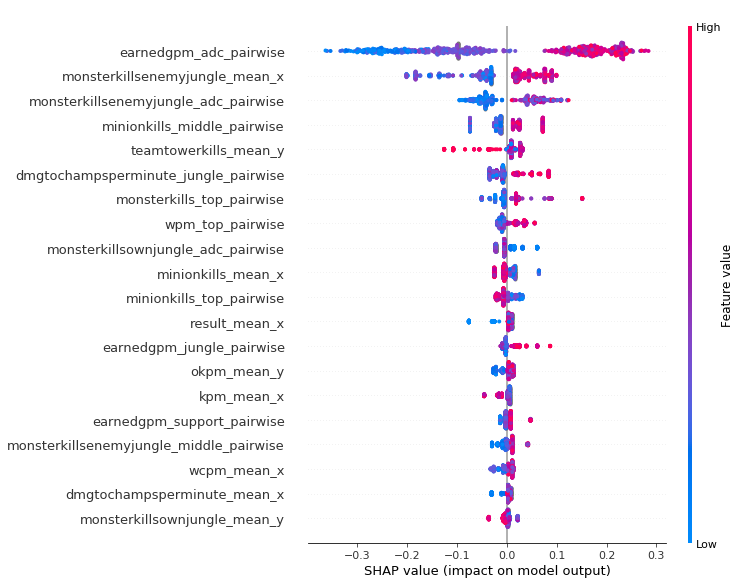

In [16]:
shap.summary_plot(shap_values_train, X_train)

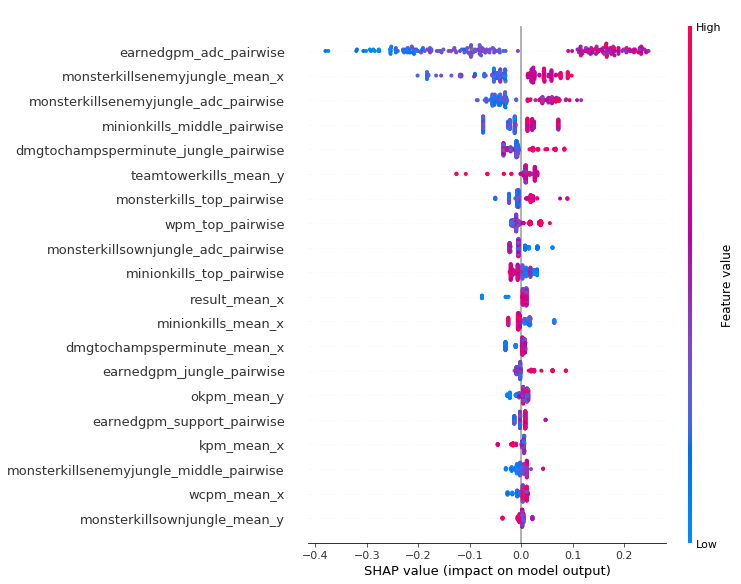

In [17]:
shap.summary_plot(shap_values_test, X_test)

---

In [93]:
%%time
# + median in mean_features_by_team
lgb_clf = lgb.LGBMClassifier(n_estimators=100,
                             max_depth=3,
                             learning_rate=1e-2)
lgb_clf.fit(X_train, y_train)
vals = lgb_clf.predict(X_train)
preds = lgb_clf.predict(X_test)
vals_proba = lgb_clf.predict_proba(X_train)[:, 1]
preds_proba = lgb_clf.predict_proba(X_test)[:, 1]

print('train',
      'roc auc {}'.format(roc_auc_score(y_train, vals)),
      'acc {}'.format(accuracy_score(y_train, vals)),
      'shape {}'.format(train_df.shape[0]))
print('test',
      'roc auc {}'.format(roc_auc_score(y_test, preds)),
      'acc {}'.format(accuracy_score(y_test, preds)),
      'shape {}'.format(test_df.shape[0]))

train roc auc 0.7400231029456257 acc 0.7450980392156863 shape 765
test roc auc 0.6888305628463108 acc 0.7019230769230769 shape 208
Wall time: 435 ms
